## Inference over a planar robotic arm - edit
This model implements a state-space model for rigid body dynamics of the robotic arm.

Our state-space $\mathbf{x} \in \mathbb{R}^6 $ includes torques $\tau_i$, angles $\theta_i$ and angular velocities $\dot{\theta}_i$. We append all static parameters in $\phi = \{L_{1}, L_{2}, M_{1}, M_{2}\}$.

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = \tau_1 \\  \mathbf{x}_2 = \tau_2 \\ \mathbf{x}_3 =\theta_1 \\ \mathbf{x}_4 =\theta_2 \\
\mathbf{x}_5 = \dot{\theta}_1 \\ \mathbf{x}_6 = \dot{\theta}_2 \end{pmatrix}, \quad \mathbf{\dot{x}} = \begin{pmatrix} 0 \\  0 \\ \mathbf{x}_5 \\ \mathbf{x}_6 \\ \mathbf{D}^{-1}(\mathbf{x}_4, \phi) [\begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix} - \mathbf{c}(\mathbf{x}_3, \mathbf{x}_4) -\mathbf{h}(\mathbf{x}_4, \mathbf{x}_5, \mathbf{x}_6) ]
\end{pmatrix}  := a(\mathbf{x})
$$

Where $\mathbf{D} \in \mathbb{R}^{2 \times 2}$ is the inertia tensor and $\mathbf{c},\mathbf{h} \in \mathbb{R}^{2}$ are gravity and fictitious forces vectors, respectively.

Note that $a(\mathbf{x})$ is non-linear because (1) the operation $\mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}$, and (2) $\mathbf{c},\mathbf{h}$ are non-linear functions of the state.

with noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0\\0\\0\end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ 0 \\ 0 \\ 0 \\0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ \sigma \\ \sigma \\ \sigma \\\sigma \end{pmatrix} \nu_t
 $$

where we introduce $\sigma<<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a(\mathbf{x}_t), \text{diag}(\Delta{t}^2,\Delta{t}^2, \sigma, \sigma, \sigma, \sigma))
$$

The emission is 

$$
g(\mathbf{y}_t | \mathbf{x}_t) = \text{FW-KIN}(\mathbf{x}_3, \mathbf{x}_4)
$$

## Concepts Explored in this notebook
The full model from torques to coordinates $\mathbf{\tau} \rightarrow \mathbf{y}$ can be estimated properly with enough independent SMC samplers. In this implementation, the batch dimension of each tensor is used as an independent SMC sampler.

For parameter learning $\theta : = \{M_1, M_2, L_1, L_2\}$, we do not need to use SMC samplers; `batch_size` could be small, even 1. in each SGD iteration, I estimate the states $\mathbf{x}$. Some SGD iterations will be good and some bad, but we assume that they're good enough. Then, offline, we use many independent particle filters.

In [1]:
import os
import inspect
print(os.getcwd())
plot_folder = 'planar_arm_dyn_plots'

/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test


In [2]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)

In [3]:
parent_dir

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc'

In [4]:
# change dir to import from aesmc
os.chdir(parent_dir)
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state
import aesmc.math as math
import aesmc.smoothing as smoothing

In [5]:
# change dir to import from aesmc/test
os.chdir(current_dir)
from arm_models import planar_arm_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords
from arm_models import utils_summary
from arm_models import fw_sim_planar_arm_dyn
from arm_models import proposal_objects

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [7]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [8]:
import pickle

# pickle utils
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as input:  # note rb and not wb
        return pickle.load(input)

In [9]:
def sim_data_from_model(model_dict, num_timesteps, batch_size, repeat_data):
    '''this utility just allows to pass a model_dict with
    "initial", "transition", and "emission" objects.'''
    sim_lats, sim_observs = statistics.sample_from_prior(
        model_dict["initial"], model_dict["transition"],
        model_dict["emission"], num_timesteps, batch_size, repeat_data)
    return sim_lats, sim_observs

In [10]:
def infer_latents(model_dict, observations, num_particles):
    """wrapper around aesmc.inference.infer that allows to input a model_dict
    with the four distribution objects. note, currently 
    Args: 
        model_dict: [dict] with initial, transition, emission, and proposal
        observations: [list] of length num_timepoints with each entry a tensor
        torch.Size(batch_size, dim_obs)
        num_particles: [int]
    Returns:
        list with latents, log_weights, etc."""
    import time as time
    start_time_fw = time.time()
    inference_result = inference.infer(
        inference_algorithm='smc',
        observations=observations,
        initial=model_dict["initial"],
        transition=model_dict["transition"],
        emission=model_dict["emission"],
        proposal=model_dict["proposal"],
        num_particles=num_particles,
        return_log_weights=True,
        return_log_marginal_likelihood=True,
    )
    print('run time for %i timesteps, %i batches, %i particles = %.2f' % \
      (len(observations), observations[-1].shape[0],
       num_particles, time.time() - start_time_fw))
    return inference_result

In [11]:
def plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict,
                       fig_full_path):
    plt.subplot(121)
    plt.plot(lat_data_np[ind_in_batch, :, :].T)
    plt.title('simulated states')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["state"])
    plt.subplot(122)
    plt.plot(sim_data_np[ind_in_batch, :, :].T)
    plt.title('simulated observations')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["obs"])
    plt.tight_layout()
    plt.savefig(fig_full_path)

In [12]:
def plot_inferred_traces_single_run(posterior_summary, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 2
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9),
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [13]:
def plot_inferred_traces(post_mean, post_var, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 2
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9),
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [91]:
def center_2D_coords(sliced):
    num_body_parts = 3
    x_offset = np.nanmean(sliced[:,0])
    y_offset = np.nanmean(sliced[:,1])
    
    temp = [x_offset,y_offset]
    temp_tile = np.tile(temp,num_body_parts)
    
    data_centered = np.copy(sliced)
    data_centered = data_centered - temp_tile
    return data_centered, x_offset, y_offset

def uncenter_2D_coords(sliced, x_offset, y_offset):
    
    num_body_parts = 3
    temp = [x_offset,y_offset]
    temp_tile = np.tile(temp,3)
    
    data_non_centered = np.copy(sliced)
    data_non_centered = data_non_centered + temp_tile
    return data_non_centered

In [92]:
def DLC_csv_to_arr(filename, ind_start, num_timesteps):
    '''add a func that reads a file name, takes a subset of observations
    and either centers or not, returns a tensor.'''
    DLC_dframe = pd.read_csv(filename, 
                             header = [1,2]) # header = [1,2] is important. Provides a hierarchical data frame
    time_index_to_analyze = np.arange(ind_start,ind_start+num_timesteps)
    print('this dataset includes %i timesteps.' % len(DLC_dframe))
    print('.....................')
    print('It looks like this:')
    print(DLC_dframe.head())
    print('.....................')
    print('analyzing steps [%i,%i].' % (time_index_to_analyze[0], time_index_to_analyze[-1]))
    
    # below applies to 2D. 3D should include a Z coordinate.
    data_arr = np.hstack([np.asarray(DLC_dframe["shoulder"][["x","y"]]),
               np.asarray(DLC_dframe["elbow"][["x","y"]]),
              np.asarray(DLC_dframe["wrist"][["x","y"]])])
    # flipped order, center before slicing.
    data_centered, x_offset, y_offset = center_2D_coords(data_arr)
    data_sliced = data_centered[time_index_to_analyze, :]
    #data_sliced = data_arr[time_index_to_analyze, :]
    #data_centered = center_2D_coords(data_sliced)
    return data_sliced, data_centered, data_arr, x_offset, y_offset, 

In [93]:
def compute_2D_norms(data_mat):
    a1_pre_norm = data_mat[:,[2,3]]-data_mat[:,[0,1]]
    a2_pre_norm = data_mat[:,[4,5]]-data_mat[:,[2,3]]
    norm_1 = np.linalg.norm(a1_pre_norm, axis=1)
    norm_2 = np.linalg.norm(a2_pre_norm, axis=1)
    return norm_1, norm_2

In [94]:
def plot_empirical_norms_hist(norm1, norm2, filename):
    plt.subplot(121)
    plt.title(r'$\hat{L}_1$')
    plt.xlabel('Pixels')
    plt.ylabel('Count')
    plt.title(r'$\hat{L}_1\;$' + 'via' + r'$\;||\mathbf{y}_{Elbow}-\mathbf{y}_{Shoulder}||_2^2$')

    plt.hist(norm1, color = 'gray')
    plt.vlines(x=np.median(norm1), 
               ymin=0, ymax=len(norm1) / 2, 
               label='median')
    plt.vlines(x=np.mean(norm1), 
               ymin=0, ymax=len(norm1) / 2, 
               linestyle = 'dashed',
               label='mean')
    plt.legend()
    plt.subplot(122)
    plt.title(r'$\hat{L}_2\;$' + 'via' + r'$\;||\mathbf{y}_{EE}-\mathbf{y}_{Elbow}||_2^2$')
    plt.xlabel('Pixels')
    plt.ylabel('Count')
    plt.hist(norm2, color = 'gray')
    plt.vlines(x=np.median(norm2), 
               ymin=0, ymax=len(norm2) / 2, 
               label='median')
    plt.vlines(x=np.mean(norm2), 
               ymin=0, ymax=len(norm2) / 2,
               linestyle = 'dashed',
               label='mean')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(filename + '.png')

In [95]:
def plot_2D_coordinate_trajectories(data_sliced):
    plt.plot(data_sliced[:,[0]], data_sliced[:,1], 'k', label = 'shoulder');
    #plt.plot(data_centered[:,[2,4]], data_centered[:,[3,5]], label = 'both');
    plt.plot(data_sliced[:,2], data_sliced[:,3], label = 'elbow');
    plt.plot(data_sliced[:,4], data_sliced[:,5], label = 'wrist');
    plt.scatter([0],[0], linewidth=10, color='r', label = 'origin')
    plt.legend()
    plt.title('joint coordinates in time')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [96]:
# running params
num_timesteps = 200
saving_interval = 10
logging_interval = 10
batch_size = 64 # 64 is good for independent SMC. the higher the better.
num_iterations = 500
num_particles = 1000

this dataset includes 444 timesteps.
.....................
It looks like this:
  bodyparts   shoulder                             elbow              \
     coords          x           y likelihood          x           y   
0         0  74.636177  134.840424        1.0  64.316162  100.043083   
1         1  74.847618  134.840424        1.0  64.441299  100.043083   
2         2  74.867821  134.840424        1.0  64.441299  100.275238   
3         3  74.867821  134.794022        1.0  64.441299  100.239220   
4         4  74.869949  134.537064        1.0  64.313255  100.043083   

                   wrist                         
  likelihood           x           y likelihood  
0        1.0  122.999008  106.958519   1.000000  
1        1.0  123.159355  107.309570   0.999999  
2        1.0  123.320763  107.323853   0.999999  
3        1.0  123.451180  107.323853   0.999999  
4        1.0  123.503670  108.042030   1.000000  
.....................
analyzing steps [50,249].
83.37052542884071 

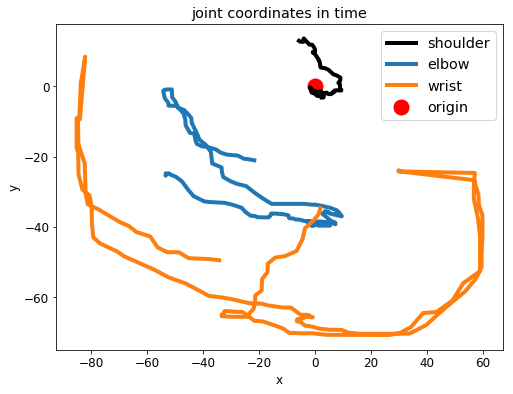

init parameters
{'L1': 41.330207660132416, 'L2': 41.10151782114738, 'M1': 1.5, 'M2': 1.5}


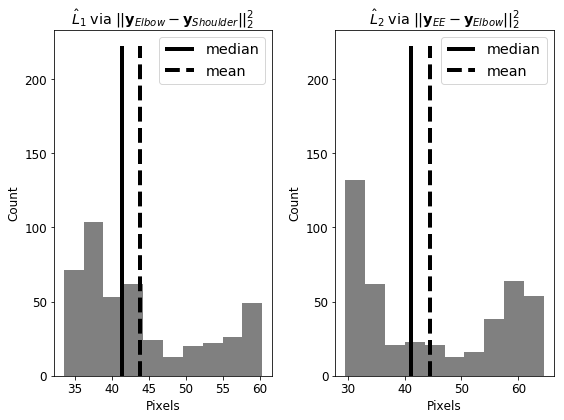

<Figure size 576x432 with 0 Axes>

In [98]:
fit_true_data = True
if fit_true_data:
    data_folder = 'datasets'
    filename = os.path.join(
    data_folder,
    'IMG_4103DLC_resnet50_HumanArmAug12shuffle1_199999filtered.csv')
    data_sliced_centered, data_centered, DLC_arr, x_offset, y_offset = DLC_csv_to_arr(filename=filename,
                               ind_start=50,
                               num_timesteps=num_timesteps)
    print(x_offset, y_offset)
    plot_2D_coordinate_trajectories(data_sliced_centered)
    # make into tensor
    observations_list = []
    for i in range(np.shape(data_sliced_centered)[0]):
        observations_list.append(torch.tensor(data_sliced_centered[i,:]).expand(batch_size, 6))
    norm1, norm2 = compute_2D_norms(data_centered)
    #print('norm median values: %.2f, %.2f' % (np.median(norm1), np.median(norm2)))
    # set a suitable inits dict
    inits_dict = {}
    inits_dict["L1"] = np.median(norm1) # 2.0
    inits_dict["L2"] = np.median(norm2) # 2.0
    inits_dict["M1"] = 1.5 # 1.1
    inits_dict["M2"] = 1.5 # 1.2
    print('init parameters')
    print(inits_dict)
    plot_empirical_norms_hist(norm1, norm2, os.path.join(data_folder, 'empirical_norms'))
# after running this I returned to the model cells and re ran them, but that doesn't make sense,
# organize data before stating the model
else:
    print('nothing')

In [21]:
# define global model params
dt = 0.03 # time interval between observations
g = 1.0 # gravity 
dim_latents = 6 # always 6 in the full planar arm model.
transition_force_scale = 20.0 # 20.0 was best also for data; tried also 10, 30, 50
transition_aux_scale = ((dt**2)*transition_force_scale**2) / (10.0) #* 2
initial_loc = 0.0 # natural choice.
initial_scale = 1.0 # 0.5 works. in future could be different per dimension.
emission_var_diag = 2.0 #note this value! 1.0 # was 0.1 before. this varies with the application. 
print('torque effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

torque effective variance: 0.36000
auxilliary variance: 0.03600


In [22]:
# put params into dicts
torque_init_scale = 1.0 
theta_init_scale = 1.0
velocity_init_scale = 1.0
param_dict = {}
param_dict["init_mu"] = initial_loc * np.ones(dim_latents)
#param_dict["init_cov"] = np.eye(dim_latents) * initial_scale
param_dict["init_cov"] = np.diag(
    np.concatenate([np.repeat(torque_init_scale**2, 2),
                    np.repeat(theta_init_scale**2, 2),
                   np.repeat(velocity_init_scale**2, 2)])) # not using initial_scale.

if fit_true_data == False:
    inits_dict = {}
    inits_dict["L1"] = 1.0  # 2.0
    inits_dict["L2"] = 1.0  # 2.0
    inits_dict["M1"] = 0.5  # 1.1
    inits_dict["M2"] = 0.3  # 1.2

In [54]:
# initialize arm model, used by transition and proposal.
# below we include_gravity_fictitious = True and transform_torques
arm_model_instance = planar_arm_dyn_model.PlanarArmDyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=False,
    constrain_phase_space=False,
    torque_dyn="Langevin")
# below is an attempt to scale Langevin_lambda with the transition force scale
arm_model_instance.Langevin_lambda = transition_force_scale * .5 # was * .3

In [55]:
arm_model_instance.Langevin_lambda

10.0

In [56]:
list(arm_model_instance.parameters())

[Parameter containing:
 tensor(41.3302),
 Parameter containing:
 tensor(41.1015),
 Parameter containing:
 tensor(1.5000),
 Parameter containing:
 tensor(1.5000)]

In [57]:
full_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
we use it to simulate ground truth data, and inference. 
with realistic data, params will have to be learned.'''

full_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

full_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_instance)

full_model["emission"] = planar_arm_dyn_model.Emission(inits_dict, #ToDo: inits_dict is now redundant for L1,L2
                                                       np.eye(6) *
                                                       emission_var_diag,
                                                       arm_model_instance,
                                                       theta_indices=[2, 3])


### choose proposal -- options:
#### Bootstrap proposal:
`proposal = planar_arm_dyn_model.Bootstrap_Proposal_Short( \
                                initial, transition)`
#### Optimal proposal:
`proposal = planar_arm_dyn_model.Optimal_Proposal(initial, transition, emission)`

In [58]:
full_model["proposal"] = proposal_objects.Bootstrap_Proposal( \
                               full_model["initial"], full_model["transition"])
# full_model["proposal"] = proposal_objects.Learned_Proposal( \
#                                full_model["initial"], 
#                                 full_model["transition"],
#                                 20,
#                                 6)

## Simulate from full model and infer states
Can we infer the true dynamics?

In [59]:
np.random.seed(0)
torch.manual_seed(0)

In [60]:
# # no need for now, this is a stable dyn. to simulate from.
# full_model["transition"].arm_model.A = 1.0* torch.tensor([[-1,1],[-1,-1]], dtype = torch.double)
# full_model["transition"].arm_model.A

In [61]:
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test'

In [66]:
# simulate from full model.
sim_lats, sim_observs = sim_data_from_model(full_model, 
                                            num_timesteps,
                                            batch_size, True)
# if simulating from a deterministic model

repeating data in batch.


In [67]:
torch.cat(sim_lats).cpu().numpy().shape

(12800, 6)

In [68]:
# just to debug, NO need to run!
full_model["transition"].arm_model.alpha_constraint = 10.0

In [69]:
debug_simulator = True
if debug_simulator:
    for i in range(50):
        sim_lats, sim_observs = sim_data_from_model(full_model, 
                                                    num_timesteps,
                                                    batch_size, True)
        print('obs')
        print(np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy())))
        print(np.nanmax(torch.cat(sim_observs).cpu().numpy()))
        print(np.nanmin(torch.cat(sim_observs).cpu().numpy()))
        print('lats')
        print(np.sum(np.isnan(torch.cat(sim_lats).cpu().numpy())))
        print(np.nanmax(torch.cat(sim_lats).cpu().numpy()))
        print(np.nanmin(torch.cat(sim_lats).cpu().numpy()))
        print('max/min angles')
        # concatenate
        lat_data = torch.cat([lat.unsqueeze(-1) for
                                   lat in sim_lats], dim=2)
        print(np.nanmax(lat_data.cpu().numpy()[:,[2,3],:])) # [batch_size, dim_latents, num_timesteps]
        print(np.nanmin(lat_data.cpu().numpy()[:,[2,3],:])) # [batch_size, dim_latents, num_timesteps]

        if np.sum(np.isnan(torch.cat(sim_observs).cpu().numpy()))>0:
            break

repeating data in batch.
obs
0
78.01639182782372
-32.52222876212059
lats
0
2.4401695236519783
-2.2299631408601783
max/min angles
2.4401695236519783
-1.831294316636369
repeating data in batch.
obs
0
82.7719108557515
-13.96337666238016
lats
0
2.3162456078622817
-2.432775148405926
max/min angles
1.8779006639061024
-1.204035032815888
repeating data in batch.
obs
0
80.02494633203717
-84.48229512707427
lats
0
2.11505679905921
-5.939990057348056
max/min angles
0.9780337599236636
-5.939990057348056
repeating data in batch.
obs
0
80.81378921065416
-80.28957264466287
lats
0
8.717199725769635
-10.351648401748873
max/min angles
2.5253420849627983
-10.351648401748873
repeating data in batch.
obs
0
83.46476273704884
-83.64978151270047
lats
0
3.758268091994732
-5.913069175387384
max/min angles
1.0757774288050217
-5.913069175387384
repeating data in batch.
obs
0
83.38060218044996
-80.26153708158269
lats
0
13.442501300059025
-10.220899626783766
max/min angles
13.442501300059025
-2.7367462070172284
repe

KeyboardInterrupt: 

In [70]:
# # if simulating from a deterministic model.
# sim_lats , sim_observs = fw_sim_planar_arm_dyn(
# sim_data(dt, num_timepoints, 
#                  param_dict, inits_dict, 
#                  sin_amp, sin_omega,
#                  sin_phase_diff, plot = True)  
# )
# print(sim_lats[-1].size()) # [batch_size, dim_latents]
# print(sim_observs[-1].size()) # [batch_size, dim_obs]

In [71]:
# concatenate and convert to numpy; for plotting.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

if torch.cuda.is_available():
    lat_data_np = lat_data.detach().cpu().numpy()
    sim_data_np = sim_data.detach().cpu().numpy()
else:
    lat_data_np = lat_data.detach().numpy()
    sim_data_np = sim_data.detach().numpy()


torch.Size([64, 6, 200])
torch.Size([64, 6, 200])


In [72]:
# labels for plots.
label_dict_full = {}
label_dict_full["state"] = [r'$\tau_1$', r'$\tau_2$', 
              r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']
label_dict_full["obs"] = [r'$x_0$', r'$y_0$',
                     r'$x_1$', r'$y_1$',
                  r'$x_2$', r'$y_2$']

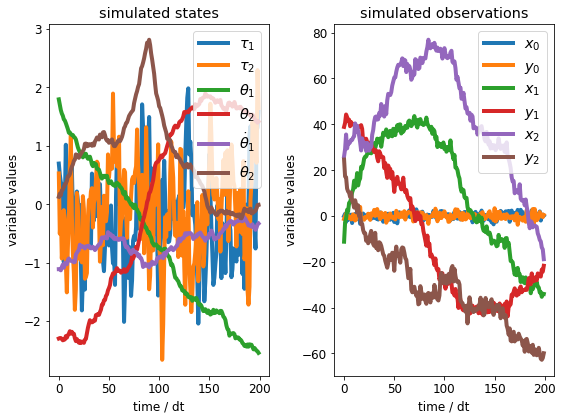

In [73]:
ind_in_batch = 8
plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict_full,
                       plot_folder + '/sim_dataset.png')

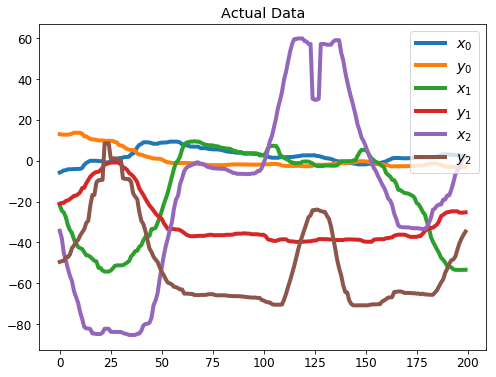

In [74]:
# if true data is being fit
plt.plot(data_sliced_centered);
plt.legend(label_dict_full["obs"])
plt.title("Actual Data");
plt.savefig('data_coords_natalie.png')

In [75]:
from scipy.special import logsumexp

In [76]:
inference_result = infer_latents(full_model, 
                                 observations_list, # sim_observs
                                 num_particles)

3.9212907257315206
3.8099638632102084
3.7630236682240703
3.7680870202043732
3.711041457867903
3.726252559381526
3.698245319952079
4.020105920335376
4.030939306224465
4.070300087861175
4.136098757556217
4.229308790758249
4.174999147799704
3.992161175695776
4.130712177772386
3.901197216348634
3.827436083297921
4.28065610228502
3.9312614430660693
3.6133627575468994
3.648589600045446
3.5594773928152557
3.5000673836770306
3.592563201513801
3.7171587660650083
3.5756819177989536
4.266171408005029
5.042941481921521
5.774069869983973
6.319794105678596
6.686415635690302
6.5620692091645285
6.20669480459704
5.118826360767329
4.401999485775469
3.7542735308264303
3.587284947064561
3.8400089806996798
3.7021171549363343
3.622769753923575
3.6939768304796154
4.2336445037980415
3.7766735335895487
3.800707956487832
3.866781245450996
3.9105272509346296
3.964710223515629
3.98076735302566
4.054221185370984
4.116311130737507
4.180245245079435
4.273832636860296
4.370648157527273
4.454127971266313
4.56520853535

In [77]:
keys = inference_result.keys()
for key in keys:
    #print(key)
    if type(inference_result[key]) is torch.Tensor:
        inference_result[key] = inference_result[key].cpu()
    elif type(inference_result[key]) is list:
        if len(inference_result[key]) > 0:
            for i in range(len(inference_result[key])):
                inference_result[key][i] = inference_result[key][i].cpu()

In [78]:
# summarize posterior separately for each batch element.
# if batches are identical, each includes an independent SMC sample
posterior_summary = utils_summary.summarize_posterior(inference_result)

In [79]:
# comparison of uniform and weighted means
# uniform:
plot_states = False

mean, var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=None,
    method='uniform')
# weighted:
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)  # typically better to remove 1/2 dominating indices

# plot the two estimates.
if plot_states:
    f, axarr = plt.subplots(2, 3, figsize=(9, 6))
    axarr = axarr.flatten()
    for i in range(lat_data_np.shape[1]):
        axarr[i].plot(lat_data_np[0, i, :], label='true')
        axarr[i].plot(mean[i, :], linestyle='dotted', label='uniform mean')
        axarr[i].plot(weighted_mean[i, :],
                      linestyle='dashed',
                      label='weighted mean')
        axarr[i].set_title(label_dict_full["state"][i])
        if i == lat_data_np.shape[1] - 1:
            plt.legend()
    f.suptitle('Full Model: Mean of %i independent BPF' % batch_size)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(plot_folder + '/mean_of_16_filters_grav.png')

applying uniform average of 64 SMC samplers.
applying weighted average of 64 SMC samplers.


(array([11]),)


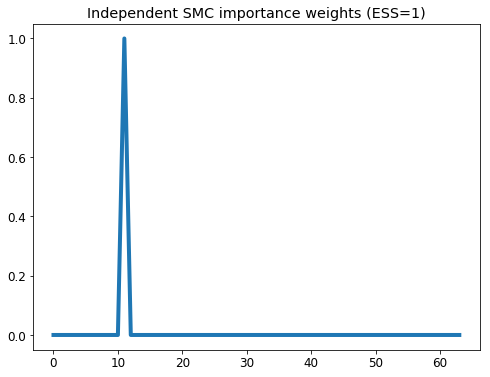

In [80]:
from scipy.special import logsumexp
logw = inference_result["log_marginal_likelihood"].detach().numpy()
w = np.exp(logw - logsumexp(logw))
plt.plot(w)
print(np.where(w==np.max(w)))
independent_SMC_ESS = 1.0 / np.sum(w**2)
#print('independent SMC ESS: %d' % independent_SMC_ESS)
plt.title('Independent SMC importance weights (ESS=%d)' % independent_SMC_ESS)
plt.savefig(os.path.join(plot_folder, 'ind_smc_importance_weights.png'))


In [81]:
np.sort(w) # note that many some w's are == 0. check that in future.

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.44118949e-320,
       4.04304601e-315, 4.16868431e-301, 1.67709528e-282, 4.76182451e-277,
       1.29974614e-269, 2.82984602e-266, 1.69388860e-265, 1.76632415e-261,
       2.61199053e-261, 5.35184742e-246, 2.62991901e-244, 5.05202243e-242,
       8.24955595e-240, 7.52476030e-233, 1.34073749e-222, 2.67898957e-214,
       5.07083813e-214, 2.73359165e-213, 5.59571913e-207, 1.00539360e-204,
       6.80764419e-202, 6.87937959e-200, 4.31746215e-192, 7.70374994e-192,
       2.00038271e-170, 7

In [36]:
#np.where(w==0)
#np.where(np.isin(w, np.sort(w)[-2:])) # which are the two best filters
#np.where(~np.isin(w, np.sort(w)[-2:])) # worst filters

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


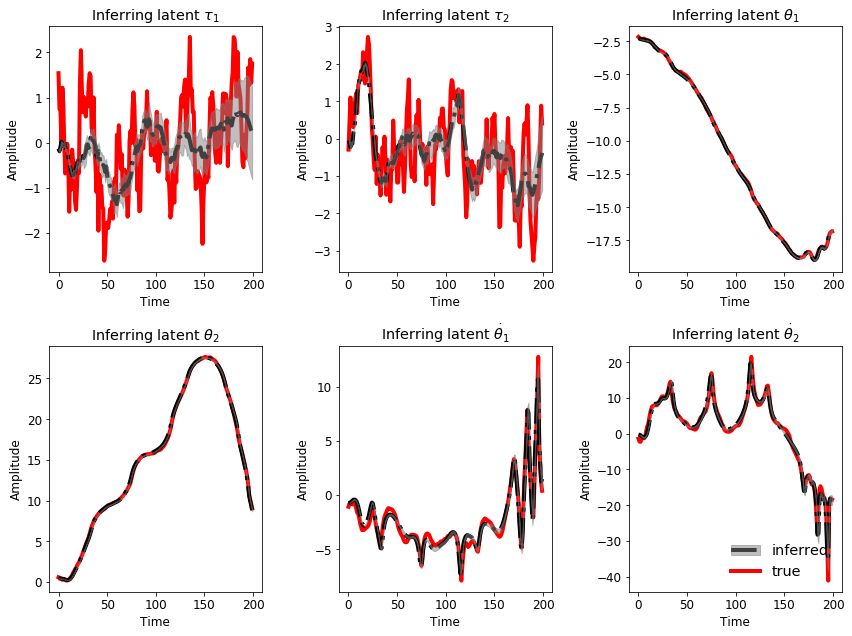

In [52]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/uniform.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=mean[i,:],
    post_var=np.sqrt(var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


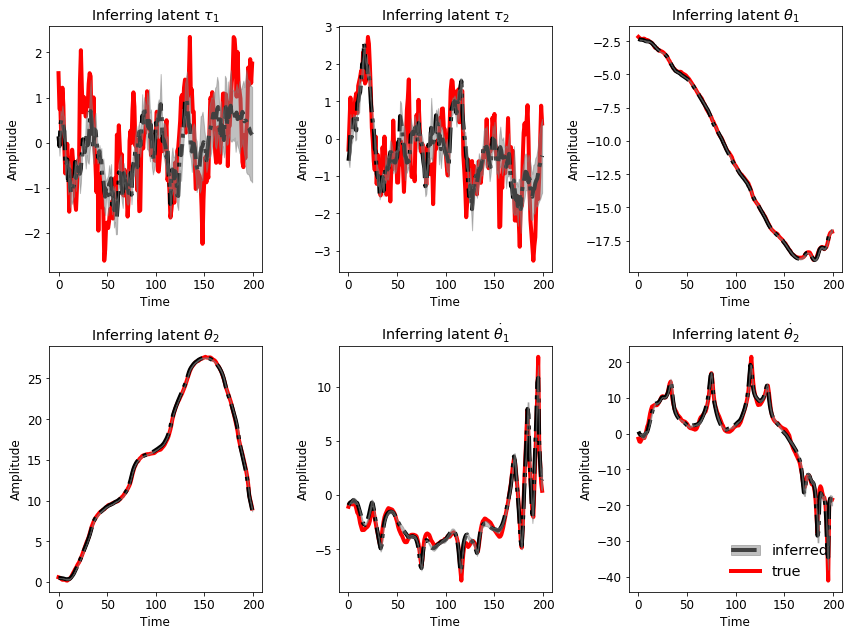

In [53]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/weighted.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_mean[i,:],
    post_var=np.sqrt(weighted_var[i,:]),
    data_vec= lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

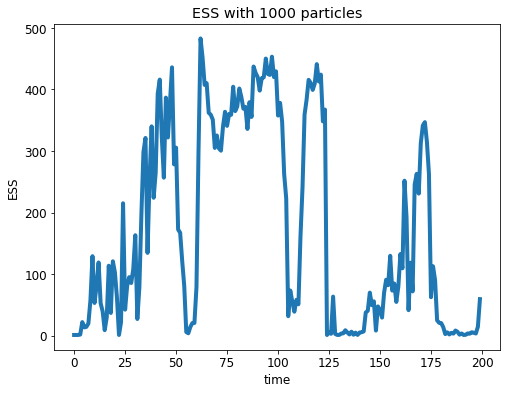

In [179]:
# plot ESS
ind_in_batch = 41
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_1.png')

In [99]:
## if simulate all the way forward to coords.
#x_obs = sim_data_np[ind_in_batch, [0,2,4], :].T
#y_obs = sim_data_np[ind_in_batch, [1,3,5], :].T
## if simulate only to angles and velocities.

x_obs, y_obs = arm_utils.coords_from_params_mat(
   lat_data_np[ind_in_batch,2,:], 
    lat_data_np[ind_in_batch,3,:], 
                inits_dict["L1"], inits_dict["L2"]) 

if fit_true_data:
    x_obs = data_sliced_centered[:,[0,2,4]] + x_offset # can remove the centering for simple plot
    y_obs = data_sliced_centered[:,[1,3,5]] + y_offset

print(y_obs.shape)

(200, 3)


In [100]:
# TODO: make sure to input right params for learning
# this is the version for weighted average of BPFs
x_hat , y_hat = arm_utils.coords_from_params_mat(
   weighted_mean[2,:], 
    weighted_mean[3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
x_hat.shape
x_hat += x_offset
y_hat += y_offset

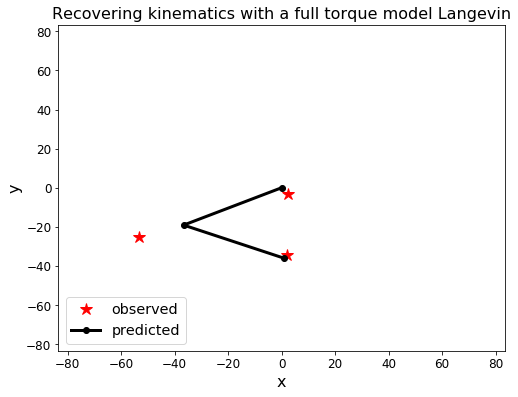

In [85]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             plot_folder+'/recover_dyn_natalie_video', 
                   "Recovering kinematics with a full torque model Langevin", 
                             x_hat.shape[0], inits_dict["L1"] + 
                             inits_dict["L2"] + 1)

In [219]:
# make sure you got the proper file name
filename = '/Users/danbiderman/Dropbox/Columbia/1.Dan/John/human_arm_videos/IMG_4103.avi'

In [86]:
os.mkdir('/Users/danbiderman/Dropbox/Columbia/1.Dan/John/human_arm_videos/IMG_4103_images')
os.system('ffmpeg -i /Users/danbiderman/Dropbox/Columbia/1.Dan/John/human_arm_videos/IMG_4103.avi -qscale:v 2 /Users/danbiderman/Dropbox/Columbia/1.Dan/John/human_arm_videos/IMG_4103_images/%03d.jpg')

0

In [113]:
import matplotlib.image as mpimg
im = mpimg.imread('/Users/danbiderman/Dropbox/Columbia/1.Dan/John/human_arm_videos/IMG_4103_images/055.jpg')

In [ ]:
os.walk()

In [183]:
image_folder = '/Users/danbiderman/Dropbox/Columbia/1.Dan/John/human_arm_videos/IMG_4103_images'
os.list(image_folder)

AttributeError: module 'os' has no attribute 'list'

In [242]:
def plot_true_recon(target_signal,
                    target_recon,
                    title,
                    legend,
                    save_dir,
                    file_name,
                    batch_ind,
                    d_interval,
                    color_list,
                    linestyle_list,
                    ax,
                    plot_until_index=None,
                    save=False):
    '''inputs: target_signal (tensor), target_recon (tensor).
    both of the same shape.
    plot_trgt_recon plots each target dimension overlayed with the recon dimension.
    we add 1 to each target dimension s.t they do will not overlap'''
    import os
    if plot_until_index is None:
        plot_max = target_signal.shape[1]
    else:
        plot_max = plot_until_index
        
    for d in range(target_signal.shape[0]):
        # we add d to each plot, such that they won't overlap.
        y_offset = d*d_interval
        ax.hlines(y=y_offset,
                   xmin=0,
                   xmax=target_signal.shape[1],
                   linewidth=0.7,
                   color="gray",
                   alpha=0.5,
                   label='_nolegend_')
        ax.plot(target_signal[d, :plot_max] + y_offset, linewidth=2, color=color_list[d],
                linestyle= linestyle_list[d])
        #plt.plot(target_recon[d,:]+d, linestyle = "dashed", color = "black");
    #plt.title("Target versus reconstruction")
    ax.set_title(title)
    #plt.legend(("target", "reconstruction"), loc = "lower right");
    ax.legend(legend, loc="lower right")
    ax.set_xlabel("time")
    ax.set_ylabel("amplitude")
    ax.set_ylim([np.min(target_signal[0,:])-1.0, 
                        np.max(target_signal[-1,:])+ y_offset+1.0])

    if save:
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        save_name = save_dir + '/' + file_name
        plt.savefig(save_name)

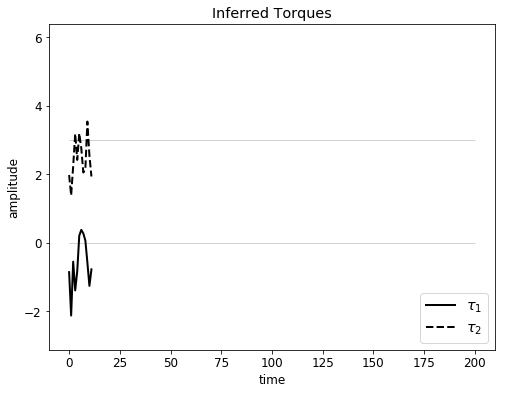

In [243]:
fig, ax = plt.subplots()
plot_true_recon(target_signal=weighted_mean[:2,:],
                target_recon=None,
                title='Inferred Torques',
                legend=[r'$\tau_1$', r'$\tau_2$'],
                save_dir=None,
                file_name=None,
                batch_ind=None,
                d_interval=3.0,
                color_list = ['black', 'black'],
                linestyle_list = ['solid', 'dashed'],
                plot_until_index = 12,
                ax = ax,
                save=False)
#plt.scatter([10], weighted_mean[:2,10])

In [188]:
# load all filenames
io_dict = {}
io_dict['images_dir'] = '/Users/danbiderman/Dropbox/Columbia/1.Dan/John/human_arm_videos/IMG_4103_images'
io_dict['image_type'] = 'jpg'
import glob
filename_list = glob.glob(
    str('%s/*.%s' % (io_dict['images_dir'], io_dict['image_type'])))
filename_list.sort()
#print(filename_list)

In [247]:
def plot_image_labels(image, 
                      coord_list_of_dicts, 
                      index, 
                      color_list,
                      linestyle_list,
                      marker_list,
                      legend_list,
                      ax = None):
    '''ToDo: add multiple data sources, so instead of x_arr, y_arr have a list of dicts
    with x,y coords. '''
    import matplotlib.image as mpimg
    nrows, ncols, _ = image.shape
    assert(len(color_list)==len(coord_list_of_dicts))
    if ax == None:
        plt.axis('off')
        plt.imshow(image, 'gray')
        plt.scatter(x_arr, y_arr)
    else:
        ax.axis('off')
        ax.set_xlim(-10,ncols+10) # pad x,y axes
        ax.set_ylim(nrows+10, -10)
        ax.imshow(image, 'gray')
        for i in range(len(coord_list_of_dicts)):
            ax.plot(coord_list_of_dicts[i]["x_coords"][index,:], 
                       coord_list_of_dicts[i]["y_coords"][index,:],
                      color = color_list[i],
                       linestyle = linestyle_list[i],
                       marker = marker_list[i])
        ax.legend(legend_list, loc = "lower right")

In [175]:
test_list = []
test_list.append({})
test_list[0]["x_coords"] = x_obs
test_list[0]["y_coords"] = y_obs
test_list.append({})
test_list[1]["x_coords"] = x_hat
test_list[1]["y_coords"] = y_hat
color_list = ["red", "blue"]
linestyle_list = ["None", "dashed"]
marker_list = ["o", "o"]
legend_list = ['DeepLabCut', 'Arm Model']

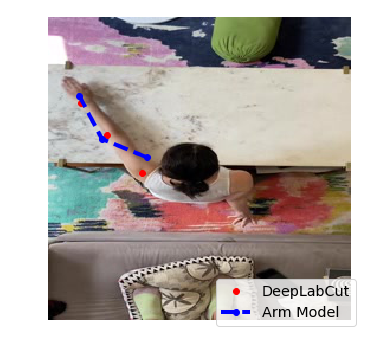

In [176]:
#im.shape
fig, ax = plt.subplots()
#print(ax)
plot_image_labels(im, test_list, 5, color_list, 
                  linestyle_list, marker_list, legend_list, ax = ax)
#ax.legend(['DeepLabCut', 'Arm Model'], loc = 'lower right')

In [181]:
DLC_arr

array([[ 74.63617706, 134.84042358,  64.31616211, 100.04308319,
        122.99900818, 106.95851898],
       [ 74.8476181 , 134.84042358,  64.44129944, 100.04308319,
        123.15935516, 107.30957031],
       [ 74.86782074, 134.84042358,  64.44129944, 100.27523804,
        123.32076263, 107.32385254],
       ...,
       [ 85.10671997, 114.54144287,  32.39488602,  88.76902771,
         91.09593964,  76.46535492],
       [ 85.10671997, 114.52959442,  31.8909111 ,  88.53522491,
         86.72078705,  72.75827789],
       [ 85.10671997, 114.52655029,  31.79596138,  88.47516632,
         83.31814575,  69.86000061]])

In [ ]:
path_images = data_folder + \
                '/' + \
                DLC_dframe["img_name", "img_name"]\
                .to_numpy()
print(path_images.shape)

In [197]:
image_folder = 'temp_images'
os.mkdir(image_folder) # make
#os.rmdir(image_folder) # remove

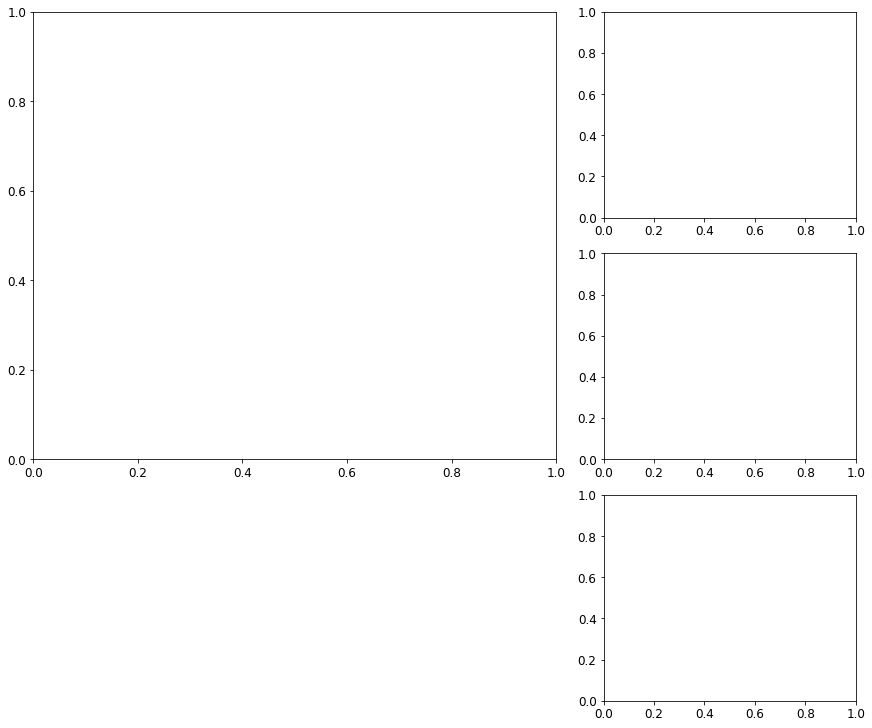

In [234]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize = (12,10))
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[:2, :2])
ax2 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[1, 2])
ax2 = fig.add_subplot(gs[2, 2])

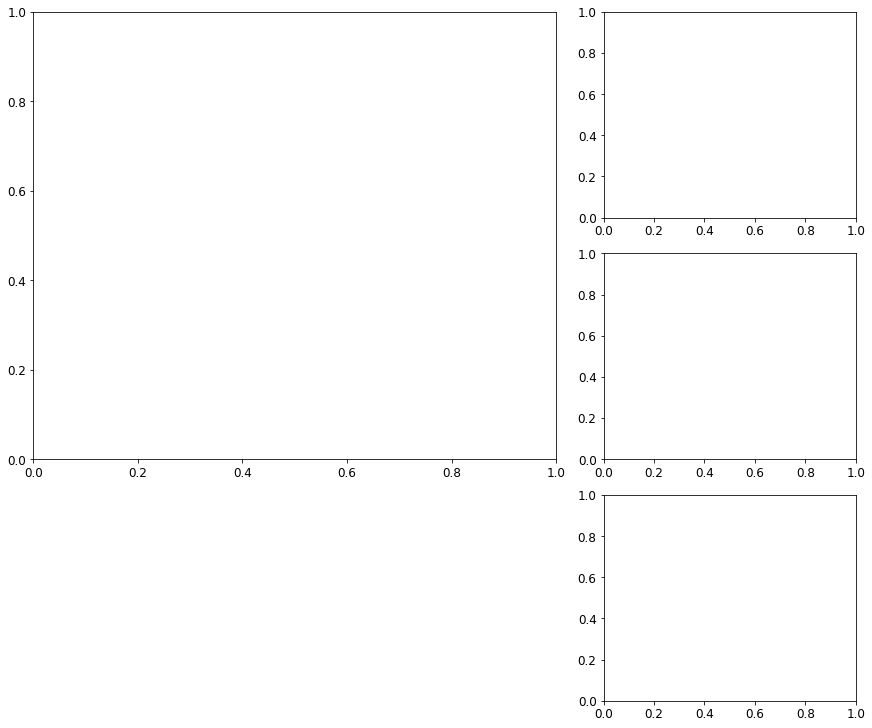

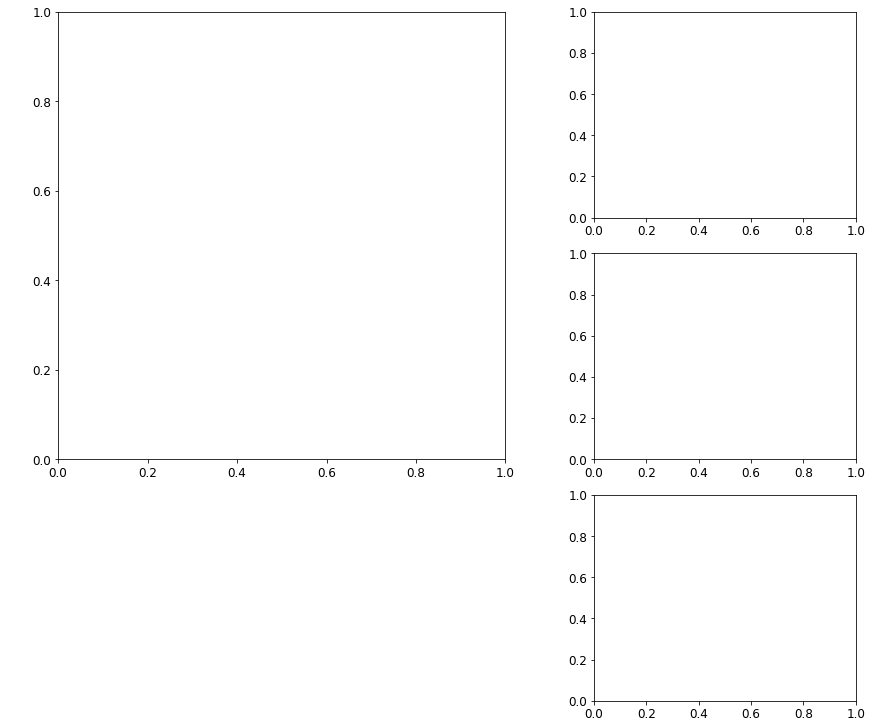

In [245]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize = (12,10))
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[:2, :2])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[2, 2])

ind_start = 50
ind_end = 50 + num_timesteps
relevant_images_list = filename_list[ind_start:ind_end]
image_nums = np.arange(ind_start, ind_end)
image_folder = 'temp_images'
os.mkdir(image_folder) # make
fig = plt.figure(constrained_layout=True, figsize = (12,10))
gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[:2, :2])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 2])
ax4 = fig.add_subplot(gs[2, 2])
for i in range(len(image_nums)):
    img = mpimg.imread(relevant_images_list[i])

    plot_image_labels(img,\
                        test_list, \
                      i,
                      color_list,
                      linestyle_list,
                      marker_list,
                      legend_list,
                      ax = ax1)
    
    plot_true_recon(target_signal=weighted_mean[:2,:],
                target_recon=None,
                title='Inferred Torques',
                legend=[r'$\tau_1$', r'$\tau_2$'],
                save_dir=None,
                file_name=None,
                batch_ind=None,
                d_interval=3.0,
                color_list = ['black', 'black'],
                linestyle_list = ['solid', 'dashed'],
                plot_until_index = i,
                ax = ax2,
                save=False)
    
    plot_true_recon(target_signal=weighted_mean[2:4,:],
                target_recon=None,
                title='Inferred Angles',
                legend=[r'$\theta_1$', r'$\theta_2$'],
                save_dir=None,
                file_name=None,
                batch_ind=None,
                d_interval=3.0,
                color_list = ['black', 'black'],
                linestyle_list = ['solid', 'dashed'],
                plot_until_index = i,
                ax = ax3,
                save=False)
    
    plot_true_recon(target_signal=weighted_mean[4:,:],
                target_recon=None,
                title='Inferred Angular Velocities',
                legend=[r'$\dot{\theta}_1$', r'$\dot{\theta}_2$'],
                save_dir=None,
                file_name=None,
                batch_ind=None,
                d_interval=3.0,
                color_list = ['black', 'black'],
                linestyle_list = ['solid', 'dashed'],
                plot_until_index = i,
                ax = ax4,
                save=False)
    
    im_int = str('%.5i' % i)
    plt.savefig(image_folder + '/' + 'im' + im_int + '.png')
    
    # clear ax
    ax1.cla()
    ax2.cla()
    ax3.cla()
    ax4.cla()
    
make_video_from_images(image_folder=image_folder, 
                       save_name=os.path.join(plot_folder, 
                                              'natalie_video_initial.avi'), 
                       fps = 30)

In [201]:
def make_video_from_images(image_folder, save_name, fps):
    # make video from these images
    import cv2
    import numpy as np
    import os
    im_list = os.listdir(image_folder)
    im_list.sort()
    im_list = im_list[1:]

    img_array = []
    for filename in im_list:
        img = cv2.imread(os.path.join(image_folder, filename))
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(save_name,
                          cv2.VideoWriter_fourcc(*'DIVX'), 
                          fps, size) # 15 fps

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [ ]:
# do something of this sort. when you have a minute. 
from matplotlib.gridspec import GridSpec
%matplotlib inline

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])
relevant_images_list = filename_list[image_nums]
for i in range(len(image_nums)):

    img = mpimg.imread(relevant_images_list[i])
   
    plot_image_labels(img,\
                        pts_2d_dict_bot_full["x_coords"][i,:], \
                        pts_2d_dict_bot_full["y_coords"][i,:],
                        color = 'red',
                          ax = ax1)
    
    ax2.azim += 1

    plot_3d_points(pose_dict_3d["x_coords"][i,:], 
               pose_dict_3d["y_coords"][i,:], 
                pose_dict_3d["z_coords"][i,:],
                lims,
                color = 'red',
               ax = ax2)
    
    im_int = str('%.5i' % i)
    plt.savefig(image_folder + '/' + 'im' + im_int + '.png')
    
    # clear both ax1 and ax2
    ax1.cla()
    ax2.cla()

In [30]:
# tested with functions. it works.
# ToDo: consider building a class that does that.
# give it the inference results and desired K realizations and it'll
# do everything.

k_realizations = 50
smoothing_result = {}  # dict of lists
smoothing_result["normalized_weights"] = []
smoothing_result["latents"] = []
smoothing_result["sampled_indices"] = []

for t in range(num_timesteps - 1, -1, -1):
    if t == num_timesteps - 1:
        normalized_weights = smoothing.expand_normalize_weights(
            inference_result["log_weights"][-1],
            k_realizations)  # Note index -1
        sampled_indices, latents = smoothing.sample_latents(
            normalized_weights, inference_result["latents"][-1])
    else:
        # compute weights
        normalized_weights = smoothing.weight_update(latents,
                                           inference_result["latents"][t],
                                           inference_result["log_weights"][t],
                                           full_model["transition"])

        sampled_indices, latents = smoothing.sample_latents(
            normalized_weights, inference_result["latents"][t])

    # these lists will all be flipped in time
    smoothing_result["normalized_weights"].append(normalized_weights)
    smoothing_result["latents"].append(latents)
    smoothing_result["sampled_indices"].append(sampled_indices)

In [31]:
# flip order
smoothing_result["normalized_weights"] = smoothing_result["normalized_weights"][::-1]
smoothing_result["latents"] = smoothing_result["latents"][::-1]
smoothing_result["sampled_indices"] = smoothing_result["sampled_indices"][::-1]

In [32]:
smoothing_result["latents"][-1].shape
posterior_summary["smooth_mean"].shape

(16, 6, 200)

In [33]:
smooth_traj = torch.cat(
    [smooth.unsqueeze(-1) for smooth in smoothing_result["latents"]], dim=3)
smooth_mean = torch.mean(smooth_traj,
                         dim=0).detach().numpy()  # over trajectories
smooth_var = torch.var(smooth_traj, dim=0).detach().numpy()

In [34]:
smooth_mean.shape
smooth_var.shape

(16, 6, 200)

In [35]:
# if batch elements are identical, take a uniform mean
mean, var = summarize_independent_smc_samplers(
    smooth_mean,
    smooth_var,
    logw=None,
    method='uniform')

applying uniform average of 16 SMC samplers.


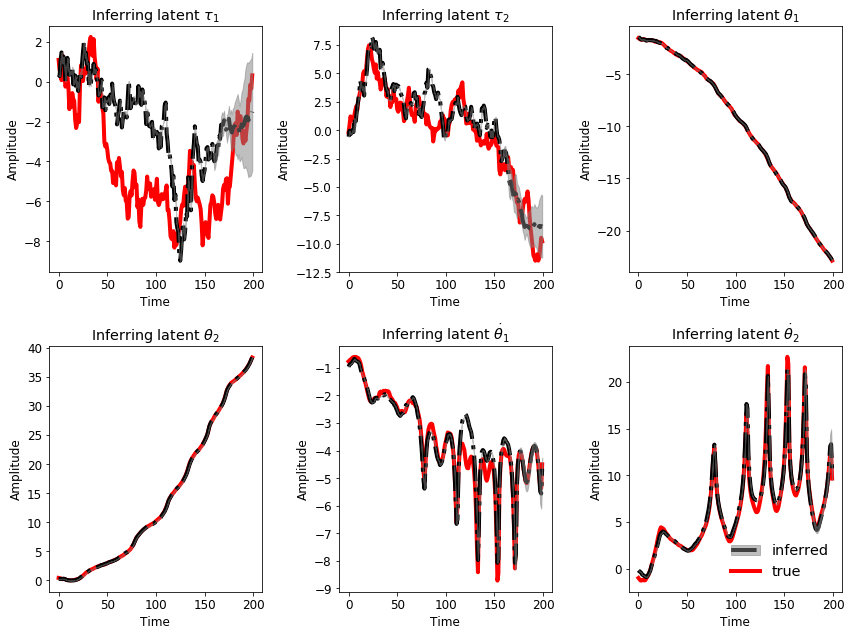

In [36]:
ind_in_batch = 6  # just one batch
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(posterior_summary["smooth_mean"].shape[1]):
    if i == 5:
        plt_leg = True
    arm_utils.plot_posterior_trace(
        post_mean=smooth_mean[ind_in_batch, i, :],
        post_var=np.sqrt(smooth_var[ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_dict_full["state"][i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
fig.tight_layout()
plt.savefig(plot_folder + '/FFBS_BPF_infer_latents.png')

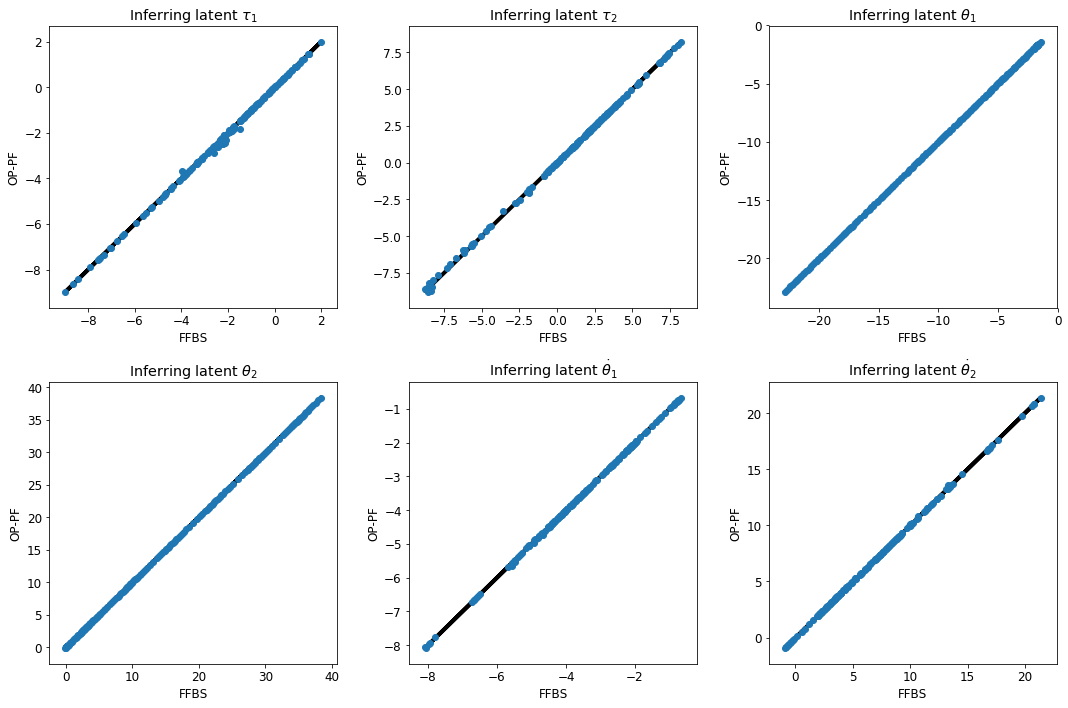

In [38]:
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
nrows = 2
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,10), sharey=False)
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(smooth_mean[ind_in_batch,i,:], 
                smooth_mean[ind_in_batch,i,:], 'k') # diag line
    axs[i].scatter(smooth_mean[ind_in_batch,i,:], 
            posterior_summary["smooth_mean"][ind_in_batch,i,:], 
                   zorder=3)
    axs[i].set_xlabel('FFBS')
    axs[i].set_ylabel('OP-PF')
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title("Inferring latent " +  label_dict_full["state"][i])

fig.tight_layout()
plt.savefig(plot_folder+'/compare_FFBS_BPF.png')

Implement learning of $M_1$ and $M_2$

In [29]:
sim_data_np.shape

(16, 6, 200)

In [35]:
sim_data_np[0, :2, :]

array([[ 5.70418582e-02, -1.26147187e-01,  7.33463124e-02,
        -1.06593631e-03,  2.47888052e-02, -2.22029565e-01,
        -8.18543951e-02, -2.51541028e-01, -8.01100919e-02,
        -2.31288582e-02, -7.02392525e-02, -1.77268907e-01,
         2.89053106e-01,  1.63828490e-02, -1.90669266e-01,
         7.54882909e-02,  1.19438432e-01,  2.13900395e-02,
         3.19796050e-02,  1.90996601e-01,  1.32161615e-01,
         1.18693354e-01,  4.96322846e-02, -5.77234386e-02,
         5.99473435e-02, -7.47436410e-02, -3.49145487e-01,
         3.36627451e-01,  2.93188017e-02,  1.38095598e-01,
         7.88760159e-02, -1.46822371e-02, -1.35461429e-01,
         3.88674974e-01,  1.61835988e-01, -8.74782858e-02,
         1.82245095e-01, -1.15807996e-01, -1.59490798e-01,
        -1.74081084e-01,  2.35196582e-01,  1.15926201e-04,
        -3.71860548e-02,  2.13730724e-01, -3.26950107e-01,
        -1.16073656e-01, -1.65290985e-01, -5.48096284e-02,
        -1.08871898e-01, -2.64580158e-01, -7.58570321e-0

In [44]:
empirical_estimate_L1 = np.linalg.norm(sim_data_np[0, 2:4, :] - sim_data_np[0, :2, :], axis=0)
empirical_estimate_L2 = np.linalg.norm(sim_data_np[0, 4:, :] - sim_data_np[0, 2:4, :], axis=0)

In [48]:
(inits_dict["L1"] - np.median(empirical_estimate_L1)) / inits_dict["L1"]

-0.003617780302634266

In [49]:
(inits_dict["L2"] - np.median(empirical_estimate_L2)) / inits_dict["L2"]

-0.009406472491689799

In [52]:
# look at fw kin learning script for variables, etc.

2.0

In [21]:
learning_inits_dict = {}
learning_inits_dict['L1'] = inits_dict["L1"] + 0.5 # for now, can be empirical estimate or learned
learning_inits_dict['L2'] = inits_dict["L1"] - 0.5 # same
learning_inits_dict['M1'] = inits_dict["M1"] - 0.6 # test init for true == 1.1
learning_inits_dict['M2'] = inits_dict["M2"] + 0.7 # test init for true == 1.1

In [22]:
arm_model_learning = planar_arm_dyn_model.PlanarArmDyn(
    dt=dt,
    inits_dict=learning_inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static= True)

In [23]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(2.5000, requires_grad=True),
 Parameter containing:
 tensor(1.5000, requires_grad=True),
 Parameter containing:
 tensor(0.5000, requires_grad=True),
 Parameter containing:
 tensor(1.9000, requires_grad=True)]

In [24]:
param_dict
# ToDo: there are more params you can add to param dict?

{'init_mu': array([0., 0., 0., 0., 0., 0.]),
 'init_cov': array([[0.5, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.5]])}

In [25]:
learning_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
here we learn M1 and M2'''

learning_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

learning_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_learning)

learning_model["emission"] = planar_arm_dyn_model.Emission(learning_inits_dict,
                                                       np.eye(6) *
                                                       emission_var_diag,
                                                        arm_model_learning,
                                                       theta_indices=[2, 3])

learning_model["proposal"] = planar_arm_dyn_model.Bootstrap_Proposal( \
                               learning_model["initial"], learning_model["transition"])

In [26]:
# running params
num_timesteps = 100
saving_interval = 10
logging_interval = 1
batch_size = 32 # 64 is good for independent SMC. the higher the better.
num_iterations = 30
num_particles = 500
num_epochs = 40

In [27]:
dataloader = train.get_synthetic_dataloader(
            full_model["initial"],
            full_model["transition"],
            full_model["emission"],
            num_timesteps, batch_size)

In [28]:
# ToDo: look at the aesmc original script for training
training_stats = planar_arm_dyn_model.TrainingStats(true_inits_dict=inits_dict,
                arm_model_instance = arm_model_learning,
                num_timesteps = num_timesteps,
                logging_interval = logging_interval)

In [30]:
arm_model_learning.to("cuda")

PlanarArmDyn()

In [ ]:
# just for now, but should be set . no need to run. can change defs here
for param in list(arm_model_learning.parameters()):
    parm.requires_grad = True
print(list(arm_model_learning.parameters()))

In [31]:
from scipy.special import logsumexp

In [32]:
train.train(dataloader=dataloader,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=num_epochs,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

each batch contains different data.
Epoch 0: Iteration 0: Loss = 2345.128165477906, Param. norm = 1.1616523068128346
each batch contains different data.
Epoch 0: Iteration 1: Loss = 2272.076158025878, Param. norm = 1.1591385412898503
each batch contains different data.
Epoch 0: Iteration 2: Loss = 1524.5450813996445, Param. norm = 1.1569021509991104
each batch contains different data.
Epoch 0: Iteration 3: Loss = 2396.791745459028, Param. norm = 1.1538503314550685
each batch contains different data.
Epoch 0: Iteration 4: Loss = 1799.8589302755197, Param. norm = 1.1515446509227707
each batch contains different data.
Epoch 0: Iteration 5: Loss = 1355.7506243092957, Param. norm = 1.149988703303553
each batch contains different data.
Epoch 0: Iteration 6: Loss = 1645.7278546609498, Param. norm = 1.1488134728777917
each batch contains different data.
Epoch 0: Iteration 7: Loss = 1468.253359870863, Param. norm = 1.1475734747116464
each batch contains different data.
Epoch 0: Iteration 8: Los

Epoch 2: Iteration 9: Loss = 2009.6877176873286, Param. norm = 1.128291427574524
each batch contains different data.
Epoch 2: Iteration 10: Loss = 2841.3948115070416, Param. norm = 1.1282648192486346
each batch contains different data.
Epoch 2: Iteration 11: Loss = 1455.905269358385, Param. norm = 1.1282453973303486
each batch contains different data.
Epoch 2: Iteration 12: Loss = 1814.176070415222, Param. norm = 1.128218915330478
each batch contains different data.
Epoch 2: Iteration 13: Loss = 1656.8386084890099, Param. norm = 1.1281996910570196
each batch contains different data.
Epoch 2: Iteration 14: Loss = 1733.3274384475303, Param. norm = 1.128166081118455
each batch contains different data.
Epoch 2: Iteration 15: Loss = 1725.4823486049368, Param. norm = 1.1281173944280622
each batch contains different data.
Epoch 2: Iteration 16: Loss = 1641.4119270742717, Param. norm = 1.1280450710971794
each batch contains different data.
Epoch 2: Iteration 17: Loss = 2123.1095971977766, Para

Epoch 4: Iteration 18: Loss = 1061.4226046200818, Param. norm = 1.1232958717951713
each batch contains different data.
Epoch 4: Iteration 19: Loss = 1820.3758407869823, Param. norm = 1.12328817022719
each batch contains different data.
Epoch 4: Iteration 20: Loss = 2194.706323001917, Param. norm = 1.1232641999968493
each batch contains different data.
Epoch 4: Iteration 21: Loss = 1231.442393262295, Param. norm = 1.1232178909101305
each batch contains different data.
Epoch 4: Iteration 22: Loss = 1927.9528170247145, Param. norm = 1.1231719315276358
each batch contains different data.
Epoch 4: Iteration 23: Loss = 1222.7961834668708, Param. norm = 1.1231185570803601
each batch contains different data.
Epoch 4: Iteration 24: Loss = 1714.7735498057577, Param. norm = 1.1230499900760462
each batch contains different data.
Epoch 4: Iteration 25: Loss = 1278.62619948138, Param. norm = 1.122934214661638
each batch contains different data.
Epoch 4: Iteration 26: Loss = 1487.0961437048536, Param

Epoch 6: Iteration 27: Loss = 1318.5735330330274, Param. norm = 1.1188786623093105
each batch contains different data.
Epoch 6: Iteration 28: Loss = 1933.6505619926631, Param. norm = 1.118742194937635
each batch contains different data.
Epoch 6: Iteration 29: Loss = 1652.069683743197, Param. norm = 1.1186135776948598
each batch contains different data.
each batch contains different data.
Epoch 7: Iteration 0: Loss = 1784.3698812896973, Param. norm = 1.118474184656722
each batch contains different data.
Epoch 7: Iteration 1: Loss = 2045.8567570025039, Param. norm = 1.118334855352293
each batch contains different data.
Epoch 7: Iteration 2: Loss = 646.223583276415, Param. norm = 1.1182023029139556
each batch contains different data.
Epoch 7: Iteration 3: Loss = 1181.5814065075726, Param. norm = 1.1180643402230754
each batch contains different data.
Epoch 7: Iteration 4: Loss = 1202.6459889958933, Param. norm = 1.1179249323609184
each batch contains different data.
Epoch 7: Iteration 5: L

Epoch 9: Iteration 6: Loss = 1005.7217773825698, Param. norm = 1.1207126969828904
each batch contains different data.
Epoch 9: Iteration 7: Loss = 839.0169762820603, Param. norm = 1.1206622320198711
each batch contains different data.
Epoch 9: Iteration 8: Loss = 1875.8800872257984, Param. norm = 1.1206246035242522
each batch contains different data.
Epoch 9: Iteration 9: Loss = 1144.6334942586568, Param. norm = 1.1205821082125438
each batch contains different data.
Epoch 9: Iteration 10: Loss = 1665.3396067417523, Param. norm = 1.1205350039272366
each batch contains different data.
Epoch 9: Iteration 11: Loss = 1442.9560906159427, Param. norm = 1.1204848192521335
each batch contains different data.
Epoch 9: Iteration 12: Loss = 1149.8070297469164, Param. norm = 1.120432540076244
each batch contains different data.
Epoch 9: Iteration 13: Loss = 1000.8915295538363, Param. norm = 1.1203870349037637
each batch contains different data.
Epoch 9: Iteration 14: Loss = 1453.6469200366955, Para

Epoch 11: Iteration 15: Loss = 1186.159031291635, Param. norm = 1.1136628904159391
each batch contains different data.
Epoch 11: Iteration 16: Loss = 968.0872253111596, Param. norm = 1.113645665913202
each batch contains different data.
Epoch 11: Iteration 17: Loss = 968.6961140067247, Param. norm = 1.1136175291871142
each batch contains different data.
Epoch 11: Iteration 18: Loss = 1130.3786592077904, Param. norm = 1.1135819300144572
each batch contains different data.
Epoch 11: Iteration 19: Loss = 1540.9983404498216, Param. norm = 1.113538512438803
each batch contains different data.
Epoch 11: Iteration 20: Loss = 2666.4590980932717, Param. norm = 1.1134917042467705
each batch contains different data.
Epoch 11: Iteration 21: Loss = 1034.4430353127573, Param. norm = 1.1134408474693651
each batch contains different data.
Epoch 11: Iteration 22: Loss = 1217.733614271467, Param. norm = 1.1133891299956205
each batch contains different data.
Epoch 11: Iteration 23: Loss = 1071.7897265803

Epoch 13: Iteration 24: Loss = 1372.7908335025209, Param. norm = 1.1077372011375906
each batch contains different data.
Epoch 13: Iteration 25: Loss = 1236.3040118283147, Param. norm = 1.1076941428800315
each batch contains different data.
Epoch 13: Iteration 26: Loss = 1019.2253646513469, Param. norm = 1.107648990812969
each batch contains different data.
Epoch 13: Iteration 27: Loss = 1425.216486662849, Param. norm = 1.107595258515972
each batch contains different data.
Epoch 13: Iteration 28: Loss = 1405.8313212261605, Param. norm = 1.1075337773494183
each batch contains different data.
Epoch 13: Iteration 29: Loss = 1968.860704022241, Param. norm = 1.1074703373972252
each batch contains different data.
each batch contains different data.
Epoch 14: Iteration 0: Loss = 1156.3671702874126, Param. norm = 1.107403831382534
each batch contains different data.
Epoch 14: Iteration 1: Loss = 859.398865988347, Param. norm = 1.1073413719765492
each batch contains different data.
Epoch 14: Ite

Epoch 16: Iteration 2: Loss = 663.0655356880834, Param. norm = 1.102841230020276
each batch contains different data.
Epoch 16: Iteration 3: Loss = 1812.8525539264924, Param. norm = 1.102780845606137
each batch contains different data.
Epoch 16: Iteration 4: Loss = 1119.4342934625201, Param. norm = 1.1027513303076433
each batch contains different data.
Epoch 16: Iteration 5: Loss = 1484.8715864333892, Param. norm = 1.1027198304157033
each batch contains different data.
Epoch 16: Iteration 6: Loss = 1592.1240898844512, Param. norm = 1.1026791140446026
each batch contains different data.
Epoch 16: Iteration 7: Loss = 2219.9989791642806, Param. norm = 1.1026343107120045
each batch contains different data.
Epoch 16: Iteration 8: Loss = 1233.9702704935767, Param. norm = 1.1025813525608825
each batch contains different data.
Epoch 16: Iteration 9: Loss = 1711.7109974707544, Param. norm = 1.102188908572331
each batch contains different data.
Epoch 16: Iteration 10: Loss = 1314.1071831167772, P

Epoch 18: Iteration 11: Loss = 1228.0394489960026, Param. norm = 1.076734002354725
each batch contains different data.
Epoch 18: Iteration 12: Loss = 1558.5363512753247, Param. norm = 1.0766382135101686
each batch contains different data.
Epoch 18: Iteration 13: Loss = 1123.0798390731118, Param. norm = 1.0765441384658834
each batch contains different data.
Epoch 18: Iteration 14: Loss = 1594.8871953075568, Param. norm = 1.076456271258515
each batch contains different data.
Epoch 18: Iteration 15: Loss = 1637.9990764105728, Param. norm = 1.0763752849914174
each batch contains different data.
Epoch 18: Iteration 16: Loss = 864.0025178949447, Param. norm = 1.0763000476321753
each batch contains different data.
Epoch 18: Iteration 17: Loss = 1219.8802815869344, Param. norm = 1.07622572600374
each batch contains different data.
Epoch 18: Iteration 18: Loss = 1290.535058907419, Param. norm = 1.0761531616640296
each batch contains different data.
Epoch 18: Iteration 19: Loss = 1241.0836583555

Epoch 20: Iteration 20: Loss = 1428.09419398833, Param. norm = 1.0740340815578928
each batch contains different data.
Epoch 20: Iteration 21: Loss = 1174.516356081762, Param. norm = 1.0739623083899508
each batch contains different data.
Epoch 20: Iteration 22: Loss = 919.8647907048396, Param. norm = 1.07389334327758
each batch contains different data.
Epoch 20: Iteration 23: Loss = 965.7859601897765, Param. norm = 1.073825142897904
each batch contains different data.
Epoch 20: Iteration 24: Loss = 878.5492745906042, Param. norm = 1.0737518018530403
each batch contains different data.
Epoch 20: Iteration 25: Loss = 1197.441269874692, Param. norm = 1.073685921046773
each batch contains different data.
Epoch 20: Iteration 26: Loss = 849.4824005647757, Param. norm = 1.0736231271603045
each batch contains different data.
Epoch 20: Iteration 27: Loss = 1824.577256161289, Param. norm = 1.0735505431566525
each batch contains different data.
Epoch 20: Iteration 28: Loss = 869.0040966485403, Par

Epoch 22: Iteration 29: Loss = 847.8006806206267, Param. norm = 1.0626328497354989
each batch contains different data.
each batch contains different data.
Epoch 23: Iteration 0: Loss = 802.0897665137759, Param. norm = 1.062481494747345
each batch contains different data.
Epoch 23: Iteration 1: Loss = 999.7854977722182, Param. norm = 1.0623558681243934
each batch contains different data.
Epoch 23: Iteration 2: Loss = 925.2958583497016, Param. norm = 1.0622465499308338
each batch contains different data.
Epoch 23: Iteration 3: Loss = 1281.982253160431, Param. norm = 1.0621529048929823
each batch contains different data.
Epoch 23: Iteration 4: Loss = 611.5333328355865, Param. norm = 1.0620748212819482
each batch contains different data.
Epoch 23: Iteration 5: Loss = 537.0237524622519, Param. norm = 1.0619966635027347
each batch contains different data.
Epoch 23: Iteration 6: Loss = 1358.6765061685203, Param. norm = 1.0619199366554617
each batch contains different data.
Epoch 23: Iteration

Epoch 25: Iteration 8: Loss = 1167.684451101165, Param. norm = 1.05898217411079
each batch contains different data.
Epoch 25: Iteration 9: Loss = 1478.0332348610705, Param. norm = 1.0588786653621567
each batch contains different data.
Epoch 25: Iteration 10: Loss = 779.3810138644817, Param. norm = 1.0587815931138653
each batch contains different data.
Epoch 25: Iteration 11: Loss = 1188.0300810446201, Param. norm = 1.0586941096475517
each batch contains different data.
Epoch 25: Iteration 12: Loss = 713.0248348746718, Param. norm = 1.0586139830718415
each batch contains different data.
Epoch 25: Iteration 13: Loss = 893.7524898946185, Param. norm = 1.058517569578661
each batch contains different data.
Epoch 25: Iteration 14: Loss = 1176.3022208974508, Param. norm = 1.0584267031987928
each batch contains different data.
Epoch 25: Iteration 15: Loss = 961.0697004338994, Param. norm = 1.0583487186878593
each batch contains different data.
Epoch 25: Iteration 16: Loss = 1206.0827438940569,

Epoch 27: Iteration 17: Loss = 503.9495926472408, Param. norm = 1.054685476316188
each batch contains different data.
Epoch 27: Iteration 18: Loss = 961.835211661504, Param. norm = 1.0546330944950713
each batch contains different data.
Epoch 27: Iteration 19: Loss = 828.0158223974238, Param. norm = 1.0545757931313184
each batch contains different data.
Epoch 27: Iteration 20: Loss = 1365.33890092509, Param. norm = 1.0545127898224893
each batch contains different data.
Epoch 27: Iteration 21: Loss = 1621.5343861367314, Param. norm = 1.0544469687903122
each batch contains different data.
Epoch 27: Iteration 22: Loss = 629.0632520723989, Param. norm = 1.0543821457650557
each batch contains different data.
Epoch 27: Iteration 23: Loss = 404.69944906804017, Param. norm = 1.05432090875795
each batch contains different data.
Epoch 27: Iteration 24: Loss = 870.0430533485394, Param. norm = 1.0542555266872877
each batch contains different data.
Epoch 27: Iteration 25: Loss = 1920.9176885741063, 

Epoch 29: Iteration 26: Loss = 636.6493463878287, Param. norm = 1.0510798260096583
each batch contains different data.
Epoch 29: Iteration 27: Loss = 887.7389079923287, Param. norm = 1.051146514035289
each batch contains different data.
Epoch 29: Iteration 28: Loss = 933.3868598487545, Param. norm = 1.051181982459039
each batch contains different data.
Epoch 29: Iteration 29: Loss = 759.1625253119066, Param. norm = 1.051193953136894
each batch contains different data.
each batch contains different data.
Epoch 30: Iteration 0: Loss = 1071.7439939595843, Param. norm = 1.0511736405215293
each batch contains different data.
Epoch 30: Iteration 1: Loss = 1288.8787860291854, Param. norm = 1.0511357960330319
each batch contains different data.
Epoch 30: Iteration 2: Loss = 518.352713122709, Param. norm = 1.051091045260296
each batch contains different data.
Epoch 30: Iteration 3: Loss = 794.4060059662411, Param. norm = 1.0510483567885789
each batch contains different data.
Epoch 30: Iteration

Epoch 32: Iteration 5: Loss = 803.368386712774, Param. norm = 1.0597487622490733
each batch contains different data.
Epoch 32: Iteration 6: Loss = 822.7138293433783, Param. norm = 1.0599743557139625
each batch contains different data.
Epoch 32: Iteration 7: Loss = 486.4258518648118, Param. norm = 1.0601325747668187
each batch contains different data.
Epoch 32: Iteration 8: Loss = 1707.6383195097217, Param. norm = 1.060237414385206
each batch contains different data.
Epoch 32: Iteration 9: Loss = 678.0055039457895, Param. norm = 1.0602965166463114
each batch contains different data.
Epoch 32: Iteration 10: Loss = 1044.0693487888464, Param. norm = 1.0603285444046948
each batch contains different data.
Epoch 32: Iteration 11: Loss = 999.1321643533079, Param. norm = 1.0603399390168555
each batch contains different data.
Epoch 32: Iteration 12: Loss = 891.9150026416794, Param. norm = 1.0603431923735551
each batch contains different data.
Epoch 32: Iteration 13: Loss = 864.7963490826639, Par

Epoch 34: Iteration 14: Loss = 560.7078977484665, Param. norm = 1.0618477167578406
each batch contains different data.
Epoch 34: Iteration 15: Loss = 732.8227672609412, Param. norm = 1.0619855358420864
each batch contains different data.
Epoch 34: Iteration 16: Loss = 780.9787409354466, Param. norm = 1.0620798375566989
each batch contains different data.
Epoch 34: Iteration 17: Loss = 819.1189246861475, Param. norm = 1.0621374794441056
each batch contains different data.
Epoch 34: Iteration 18: Loss = 830.3168921427523, Param. norm = 1.0621350646750078
each batch contains different data.
Epoch 34: Iteration 19: Loss = 637.9048586292045, Param. norm = 1.062109213368039
each batch contains different data.
Epoch 34: Iteration 20: Loss = 885.765532370105, Param. norm = 1.0620810093413051
each batch contains different data.
Epoch 34: Iteration 21: Loss = 750.9514028629925, Param. norm = 1.0620498346079341
each batch contains different data.
Epoch 34: Iteration 22: Loss = 545.9428677466426, 

Epoch 36: Iteration 23: Loss = 482.2400136509555, Param. norm = 1.0602181552519905
each batch contains different data.
Epoch 36: Iteration 24: Loss = 770.8677247519735, Param. norm = 1.0601241155379177
each batch contains different data.
Epoch 36: Iteration 25: Loss = 879.4137948220822, Param. norm = 1.0600346143653172
each batch contains different data.
Epoch 36: Iteration 26: Loss = 953.325099729771, Param. norm = 1.0600853161967179
each batch contains different data.
Epoch 36: Iteration 27: Loss = 1339.3149366918767, Param. norm = 1.0601658196645476
each batch contains different data.
Epoch 36: Iteration 28: Loss = 841.1705367465266, Param. norm = 1.060211510579908
each batch contains different data.
Epoch 36: Iteration 29: Loss = 1698.9351457487517, Param. norm = 1.06023542064539
each batch contains different data.
each batch contains different data.
Epoch 37: Iteration 0: Loss = 1115.4823825986505, Param. norm = 1.0602442356222284
each batch contains different data.
Epoch 37: Iter

Epoch 39: Iteration 2: Loss = 587.1525800021293, Param. norm = 1.0435125580455584
each batch contains different data.
Epoch 39: Iteration 3: Loss = 1610.0461834177102, Param. norm = 1.0434890021415062
each batch contains different data.
Epoch 39: Iteration 4: Loss = 710.7943188230649, Param. norm = 1.043468607834949
each batch contains different data.
Epoch 39: Iteration 5: Loss = 513.1736017474136, Param. norm = 1.0434431681592724
each batch contains different data.
Epoch 39: Iteration 6: Loss = 733.8261707376774, Param. norm = 1.0434146508162776
each batch contains different data.
Epoch 39: Iteration 7: Loss = 969.335780815008, Param. norm = 1.0433887702423668
each batch contains different data.
Epoch 39: Iteration 8: Loss = 1613.8482024007683, Param. norm = 1.0433891407151998
each batch contains different data.
Epoch 39: Iteration 9: Loss = 493.575750058101, Param. norm = 1.0433939705842898
each batch contains different data.
Epoch 39: Iteration 10: Loss = 810.8590335800789, Param. 

In [33]:
training_stats.curr_params_list

[array([2.49700022, 1.49699986, 0.49700004, 1.89699984]),
 array([2.49400926, 1.49793363, 0.4989669 , 1.89731312]),
 array([2.49107742, 1.49938333, 0.50068009, 1.89818633]),
 array([2.488065  , 1.50084352, 0.50290495, 1.89820015]),
 array([2.4851253 , 1.50281751, 0.50551438, 1.90007496]),
 array([2.48240852, 1.50460708, 0.50689256, 1.90183008]),
 array([2.47966623, 1.50586808, 0.50735027, 1.90305948]),
 array([2.47681284, 1.50688112, 0.50774562, 1.90401912]),
 array([2.47378564, 1.50753689, 0.50755501, 1.90464509]),
 array([2.47074509, 1.50797939, 0.50734842, 1.90505576]),
 array([2.46790624, 1.50833714, 0.50741404, 1.90537548]),
 array([2.4668138 , 1.50765264, 0.50564218, 1.90488935]),
 array([2.4658637 , 1.50678515, 0.50434196, 1.90419471]),
 array([2.46639371, 1.50420797, 0.50180221, 1.90163028]),
 array([2.46706963, 1.50164759, 0.49926013, 1.8990767 ]),
 array([2.4672091 , 1.49973607, 0.49735665, 1.89717078]),
 array([2.4668169 , 1.49832559, 0.49593547, 1.89576614]),
 array([2.4659

In [34]:
params = np.asarray(training_stats.curr_params_list)
print(params)

[[2.49700022 1.49699986 0.49700004 1.89699984]
 [2.49400926 1.49793363 0.4989669  1.89731312]
 [2.49107742 1.49938333 0.50068009 1.89818633]
 ...
 [2.16396403 1.48020077 0.50613308 1.86156929]
 [2.16436934 1.4805733  0.50662583 1.86199868]
 [2.16406298 1.48040545 0.5069297  1.8618288 ]]


In [47]:
list(inits_dict.keys())[0]

'L1'

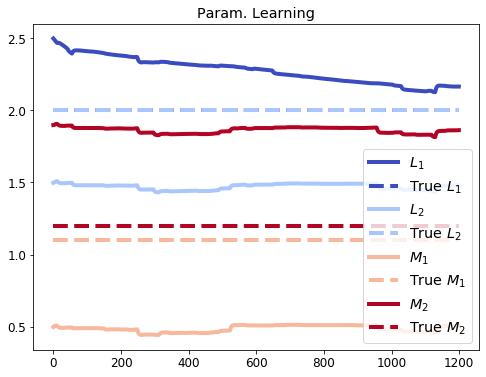

In [56]:
from matplotlib.pyplot import cm
param_label_list = [r"$L_1$", r"$L_2$", r"$M_1$", r"$M_2$"]
key_list = list(inits_dict.keys())
color=iter(cm.coolwarm(np.linspace(0,1,len(key_list))))
for i in range(params.shape[1]):
    c = next(color)
    plt.plot(params[:,i], label = param_label_list[i], c=c)
    plt.plot([0, len(params)], [inits_dict[key_list[i]], inits_dict[key_list[i]]], \
                                label = "True " + param_label_list[i],
            linestyle = "dashed", c=c)
plt.legend()
plt.title("Param. Learning")
plt.savefig(plot_folder + '/param_learning.png')

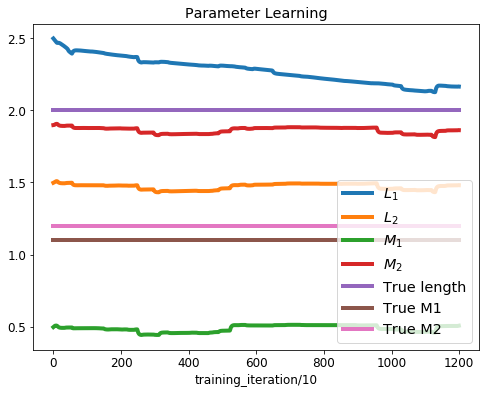

In [43]:
plt.title('Parameter Learning')
plt.plot(params[:,0], label = r"$L_1$")
plt.plot(params[:,1], label = r"$L_2$")
plt.plot(params[:,2], label = r"$M_1$")
plt.plot(params[:,3], label = r"$M_2$")
plt.plot([0, len(params)], [2.0, 2.0], label = "True length")
plt.plot([0, len(params)], [inits_dict["M1"], inits_dict["M1"]], label = "True M1")
plt.plot([0, len(params)], [inits_dict["M2"], inits_dict["M2"]], label = "True M2")

plt.xlabel('training_iteration/10')
plt.legend()

$M_1 : = 1, M_2 = \lambda \cdot M_1$ 
since we can init $L$ properly from observations, maybe fix $L$'s and $M_1$ -- can we infer $M_2$?
If this becomes hard, just fix all params and ignore the learning problem.

In [49]:
L1_in_training  = np.zeros(len(training_stats.curr_params_list))
L2_in_training  = np.zeros(len(training_stats.curr_params_list))

for i in range(len(training_stats.curr_params_list)):
    L1_in_training[i] = training_stats.curr_params_list[i][0]
    L2_in_training[i] = training_stats.curr_params_list[i][1]

NameError: name 'L1_in_training' is not defined

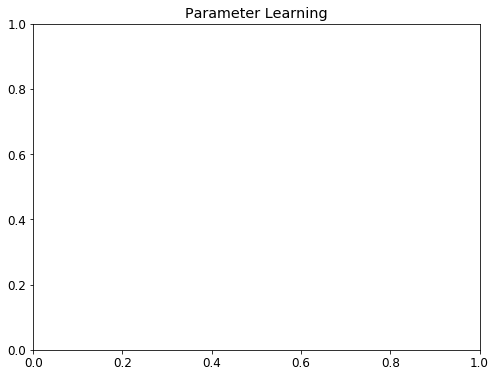

In [57]:
plt.title('Parameter Learning')
plt.plot(L1_in_training, label = r"$L_1$")
plt.plot(L2_in_training, label = r"$L_2$")
plt.plot([0, len(L1_in_training)], [2.0, 2.0], 'k', label = "True length")
plt.xlabel('training_iteration/10')
plt.legend()

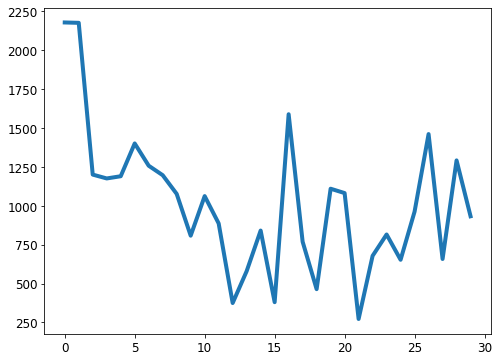

In [56]:
plt.plot(training_stats.loss)

In [61]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(2.0476, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(1.9407, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(2., device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(1.2000, device='cuda:0', requires_grad=True)]

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [62]:
learning_model["transition"].to(device)

Transition(
  (arm_model): PlanarArmDyn()
)

In [57]:
type(learning_model["transition"])

arm_models.planar_arm_dyn_model.Transition

In [64]:
learning_model["transition"].diag_mat.device

device(type='cpu')

In [65]:
torch.cuda.empty_cache()

In [70]:
list(learning_model["transition"].parameters())

[Parameter containing:
 tensor(0.7084, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(1.5079, device='cuda:0', requires_grad=True)]

In [69]:
learning_model["transition"].cuda()

Transition(
  (arm_model): PlanarArmDyn()
)

In [72]:
learning_model["transition"].diag_mat.to(device)

tensor([[0.3600, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3600, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0013, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0013, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0013, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0013]], device='cuda:0',
       dtype=torch.float64)